In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240521%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240521T183936Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f8e97d5920fdca72c78d2b9d5556bd2b6069e26011da6320e23739e84ba6bb4440d3587b75531a712e31d4bbfbd958490e06d881008e92c5ef9ab41352b527c9021dae52f4f7faba4069309db68725db2beb35649b2170f3565d07aa55d8cb00e3b83624bd0eb8c95b712b4abc0972c0009ea2e8d568e2bfaf6c4af2474780c465bb3b12f40d3d1195bafd330374d03facebe96f336c92ffb5da3214039d1d4bcdda188327f6cfc769d6884b1009aa47544a474208faddea02e89994d4696bc3651e55cb67201da1368932c3efc5a3df8d553a43032ae70ea77e52ee7c08fce307f57f358df22b8ca67565fdd9a9920c93b76221111119ed052653b5a6c61fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [3]:
data = np.array(data)
data.shape

m, n = data.shape

np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

_ , m_train = X_train.shape

In [4]:
Y_train

array([3, 8, 0, ..., 7, 4, 7])

In [5]:
def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5

    return w1, b1, w2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def ReLU_derive(Z):
    return Z > 0

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(w1, b1, w2, b2, X):
    Z1 = w1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = w2.dot(A1) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot(Y)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = w2.T.dot(dZ2) * ReLU_derive(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)

    return dW1, db1, dW2, db2

def update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, alpha):
    w1 = w1 - alpha * dW1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dW2
    b2 = b2 - alpha * db2

    return w1, b1, w2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    w1, b1, w2, b2 = init_params()

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(w1, b1, w2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))

    return w1, b1, w2, b2

In [6]:
w1, b1, w2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[1 5 1 ... 5 1 1] [3 8 0 ... 7 4 7]
0.11453658536585366
Iteration:  10
[2 6 0 ... 4 3 6] [3 8 0 ... 7 4 7]
0.19046341463414634
Iteration:  20
[2 6 0 ... 9 7 6] [3 8 0 ... 7 4 7]
0.28524390243902437
Iteration:  30
[2 6 0 ... 7 7 6] [3 8 0 ... 7 4 7]
0.35321951219512193
Iteration:  40
[2 6 0 ... 7 7 6] [3 8 0 ... 7 4 7]
0.4015609756097561
Iteration:  50
[2 8 0 ... 7 7 6] [3 8 0 ... 7 4 7]
0.43814634146341463
Iteration:  60
[2 8 0 ... 7 7 7] [3 8 0 ... 7 4 7]
0.4667317073170732
Iteration:  70
[2 8 0 ... 7 7 7] [3 8 0 ... 7 4 7]
0.4921951219512195
Iteration:  80
[2 8 0 ... 7 7 7] [3 8 0 ... 7 4 7]
0.5141707317073171
Iteration:  90
[2 8 0 ... 7 4 7] [3 8 0 ... 7 4 7]
0.5345609756097561
Iteration:  100
[2 8 0 ... 7 4 9] [3 8 0 ... 7 4 7]
0.5520243902439025
Iteration:  110
[2 8 0 ... 7 4 9] [3 8 0 ... 7 4 7]
0.5704878048780487
Iteration:  120
[2 8 0 ... 7 4 9] [3 8 0 ... 7 4 7]
0.5877073170731707
Iteration:  130
[2 8 0 ... 7 4 9] [3 8 0 ... 7 4 7]
0.6031219512195122
Iteration:  

In [14]:
def make_predictions(X, w1, b1, w2, b2):
    _, _, _, A2 = forward_prop(w1, b1, w2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, w1, b1, w2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], w1, b1, w2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  <function get_predictions at 0x79158f384700>
Label:  7


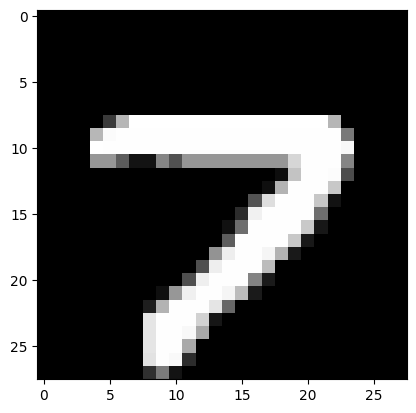

In [8]:
test_prediction(125, w1, b1, w2, b2)

In [15]:
dev_predictions = make_predictions(X_dev, w1, b1, w2, b2)
get_accuracy(dev_predictions, Y_dev)

[5 2 6 2 5 2 5 8 9 0 5 9 4 6 6 7 1 7 5 0 1 7 9 0 2 9 8 4 5 9 6 7 5 5 0 0 1
 5 6 6 8 2 4 1 1 8 3 4 0 5 3 9 5 3 4 4 6 8 0 7 7 5 7 4 6 3 5 9 7 6 7 6 6 6
 6 2 3 8 3 7 5 7 9 4 1 6 9 0 0 1 6 7 2 4 9 7 1 3 4 6 1 5 5 7 4 5 6 2 6 8 6
 3 9 3 0 4 8 4 3 3 2 7 2 8 6 1 0 3 8 3 6 3 9 6 4 1 8 2 3 5 5 6 9 5 2 2 8 4
 2 3 3 3 9 7 7 6 5 3 4 0 3 5 6 1 8 9 9 6 3 7 2 1 5 7 1 7 8 2 6 0 0 3 4 2 0
 3 8 6 0 2 1 7 2 4 0 9 3 5 6 0 9 1 8 5 7 7 1 1 7 0 4 5 1 8 4 7 5 4 7 2 1 2
 8 9 6 2 2 2 7 8 6 4 8 8 3 6 6 3 2 4 4 6 1 8 2 9 8 0 3 9 8 8 7 1 5 8 8 3 0
 3 3 9 5 0 1 3 3 5 0 5 8 9 2 2 9 9 7 4 4 2 7 4 7 0 5 6 6 8 3 0 4 3 0 4 2 4
 1 5 1 5 3 1 5 7 0 7 1 3 8 6 9 3 0 6 2 1 1 8 2 1 9 0 8 5 1 1 6 6 5 3 6 1 3
 0 6 8 5 4 5 2 7 4 0 9 1 5 6 3 5 6 2 2 9 8 4 2 8 3 8 0 8 0 5 5 6 6 7 6 0 9
 6 5 9 1 2 9 3 6 7 8 0 8 6 2 0 3 0 7 4 3 5 6 6 1 1 0 7 1 6 7 8 3 9 9 3 3 9
 5 1 5 3 3 6 4 3 1 5 6 1 6 4 4 0 2 0 1 5 1 9 5 9 0 6 1 4 0 0 8 1 6 0 1 2 2
 6 1 0 1 1 8 1 6 0 6 1 3 3 1 5 5 2 5 8 3 3 9 3 2 9 4 1 0 6 3 1 1 9 6 9 4 4
 7 6 5 5 3 9 8 7 6 7 9 2 

0.83

In [27]:
model = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}
np.savez("model.npz", **model)

In [28]:
loaded_model = np.load("model.npz")
w1 = loaded_model['w1']
b1 = loaded_model['b1']
w2 = loaded_model['w2']
b2 = loaded_model['b2']

In [29]:
dev_predictions = make_predictions(X_dev, w1, b1, w2, b2)
get_accuracy(dev_predictions, Y_dev)

[5 2 6 2 5 2 5 8 9 0 5 9 4 6 6 7 1 7 5 0 1 7 9 0 2 9 8 4 5 9 6 7 5 5 0 0 1
 5 6 6 8 2 4 1 1 8 3 4 0 5 3 9 5 3 4 4 6 8 0 7 7 5 7 4 6 3 5 9 7 6 7 6 6 6
 6 2 3 8 3 7 5 7 9 4 1 6 9 0 0 1 6 7 2 4 9 7 1 3 4 6 1 5 5 7 4 5 6 2 6 8 6
 3 9 3 0 4 8 4 3 3 2 7 2 8 6 1 0 3 8 3 6 3 9 6 4 1 8 2 3 5 5 6 9 5 2 2 8 4
 2 3 3 3 9 7 7 6 5 3 4 0 3 5 6 1 8 9 9 6 3 7 2 1 5 7 1 7 8 2 6 0 0 3 4 2 0
 3 8 6 0 2 1 7 2 4 0 9 3 5 6 0 9 1 8 5 7 7 1 1 7 0 4 5 1 8 4 7 5 4 7 2 1 2
 8 9 6 2 2 2 7 8 6 4 8 8 3 6 6 3 2 4 4 6 1 8 2 9 8 0 3 9 8 8 7 1 5 8 8 3 0
 3 3 9 5 0 1 3 3 5 0 5 8 9 2 2 9 9 7 4 4 2 7 4 7 0 5 6 6 8 3 0 4 3 0 4 2 4
 1 5 1 5 3 1 5 7 0 7 1 3 8 6 9 3 0 6 2 1 1 8 2 1 9 0 8 5 1 1 6 6 5 3 6 1 3
 0 6 8 5 4 5 2 7 4 0 9 1 5 6 3 5 6 2 2 9 8 4 2 8 3 8 0 8 0 5 5 6 6 7 6 0 9
 6 5 9 1 2 9 3 6 7 8 0 8 6 2 0 3 0 7 4 3 5 6 6 1 1 0 7 1 6 7 8 3 9 9 3 3 9
 5 1 5 3 3 6 4 3 1 5 6 1 6 4 4 0 2 0 1 5 1 9 5 9 0 6 1 4 0 0 8 1 6 0 1 2 2
 6 1 0 1 1 8 1 6 0 6 1 3 3 1 5 5 2 5 8 3 3 9 3 2 9 4 1 0 6 3 1 1 9 6 9 4 4
 7 6 5 5 3 9 8 7 6 7 9 2 

0.83